In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/power_line_IR/final.zip'

Archive:  /content/drive/MyDrive/power_line_IR/final.zip
  inflating: final/TV_IR_0003.bmp    
  inflating: final/TV_IR_0005.bmp    
  inflating: final/TV_IR_0010.bmp    
  inflating: final/TV_IR_0011.bmp    
  inflating: final/TV_IR_0015.bmp    
  inflating: final/TV_IR_0016.bmp    
  inflating: final/TV_IR_0021.bmp    
  inflating: final/TV_IR_0025.bmp    
  inflating: final/TV_IR_0035.bmp    
  inflating: final/TV_IR_0043.bmp    
  inflating: final/TV_IR_0053.bmp    
  inflating: final/TV_IR_0054.bmp    
  inflating: final/TV_IR_0055.bmp    
  inflating: final/TV_IR_0056.bmp    
  inflating: final/TV_IR_0057.bmp    
  inflating: final/TV_IR_0059.bmp    
  inflating: final/TV_IR_0061.bmp    
  inflating: final/TV_IR_0063.bmp    
  inflating: final/TV_IR_0065.bmp    
  inflating: final/TV_IR_0068.bmp    
  inflating: final/TV_IR_0072.bmp    
  inflating: final/TV_IR_0077.bmp    
  inflating: final/TV_IR_0082.bmp    
  inflating: final/TV_IR_0084.bmp    
  inflating: final/TV_IR_0089.b

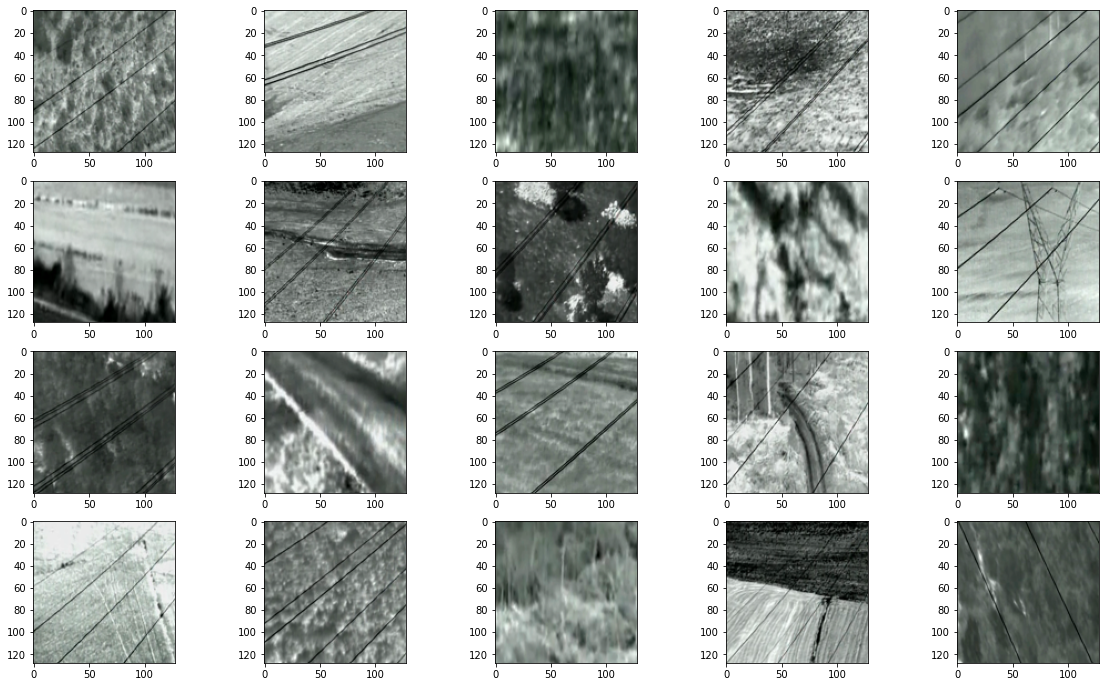

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import cv2

path = '/content/final'
images = os.listdir(path)
random.seed(2)
some_images = random.sample(images, 20)
row = 0
index = 1
plt.figure(figsize=(20,12))
for image in some_images:
  image_path = os.path.join(path, image)
  if image_path.endswith("hdf5") or os.path.isdir(image_path):
    continue
  img = cv2.imread(image_path)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 load images as BGR, convert it to RGB
  plt.subplot(4, 5, row*5+index)
  plt.imshow(img)
  index += 1
  if index == 6:
    row += 1
    index = 1

# Feature Extraction

In [ ]:
# Adapted from https://github.com/christiansafka/img2vec
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np

class Img2Vec():
    RESNET_OUTPUT_SIZES = {
        'resnet18': 128,
    }

    def __init__(self, cuda=False, model='resnet-18', layer='default', layer_output_size=512):
        """ Img2Vec
        :param cuda: If set to True, will run forward pass on GPU
        :param model: String name of requested model
        :param layer: String or Int depending on model.
        :param layer_output_size: Int depicting the output size of the requested layer
        """
        print("Using: ", model, " for feature extraction.")
        self.device = torch.device("cuda" if cuda else "cpu")

        self.model_name = model
        self.layer_output_size = layer_output_size

        self.model, self.extraction_layer = self._get_model_and_layer(
            model, layer)

        self.model = self.model.to(self.device)

        self.model.eval()

        self.scaler = transforms.Resize((224, 224))
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.to_tensor = transforms.ToTensor()

    def get_vec(self, img):
        """ Get vector embedding from PIL image
        :param img: PIL Image
        :param tensor: If True, get_vec will return a FloatTensor instead of Numpy array
        :returns: Numpy ndarray
        """
        if type(img) == list:
            a = [self.normalize(self.to_tensor(self.scaler(im))) for im in img]
            images = torch.stack(a).to(self.device)
            my_embedding = torch.zeros(len(img), self.layer_output_size, 1, 1)

            def copy_data(m, i, o):
                my_embedding.copy_(o.data)

            h = self.extraction_layer.register_forward_hook(copy_data)
            with torch.no_grad():
                h_x = self.model(images)
            h.remove()

            return my_embedding.numpy()[:, :, 0, 0]
        else:
          image = self.normalize(self.to_tensor(
              self.scaler(img))).unsqueeze(0).to(self.device)


          my_embedding = torch.zeros(1, self.layer_output_size, 1, 1)

          def copy_data(m, i, o):
              my_embedding.copy_(o.data)

          h = self.extraction_layer.register_forward_hook(copy_data)
          with torch.no_grad():
              h_x = self.model(image)
          h.remove()
          return my_embedding.numpy()[0, :, 0, 0]


    def _get_model_and_layer(self, model_name, layer):
        """ Internal method for getting layer from model
        :param model_name: model name such as 'resnet-18'
        :param layer: layer as a string for resnet-18 or int for alexnet
        :returns: pytorch model, selected layer
        """
        if model_name.startswith('resnet') and not model_name.startswith('resnet-'):
            model = getattr(models, model_name)(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = self.RESNET_OUTPUT_SIZES[model_name]
            else:
                layer = model._modules.get(layer)
            return model, layer
        elif model_name == 'resnet-18':
            model = models.resnet18(pretrained=True)
            if layer == 'default':
                layer = model._modules.get('avgpool')
                self.layer_output_size = 512
            else:
                layer = model._modules.get(layer)

            return model, layer
        else:
            raise KeyError('Model %s was not found' % model_name)

In [ ]:
from PIL import Image
import h5py
import os

def extractFeatures(path, method):
  hdf5_path = os.path.join(path, 'features_'+method+'.hdf5')
  f = h5py.File(hdf5_path, mode='w')
  if method.startswith('resnet') or method == 'alexnet' or method == 'vgg' or method == 'densenet':
    img2vec = Img2Vec(cuda=False, model=method)
    images = os.listdir(path)
    imgs = []
    # features = []
    image_list = []
    index = 1
    for image in images:
      if image.endswith('hdf5') or os.path.isdir(os.path.join(path, image)):
        continue
      # print(image, index)
      image_path = os.path.join(path, image)
      img = Image.open(image_path).convert('RGB')
      # print(img.shape)
      imgs.append(img)
      # vector = img2vec.get_vec(img)
      # features.append(vector)
      image_list.append(image)
      index += 1
    vectors = img2vec.get_vec(imgs)
    # vectors = np.asarray(features, dtype=np.float32)
    print("Features from ", method, vectors.shape)
    f.create_dataset("features", data=vectors)
    f.create_dataset("images", data=image_list)
    f.close()

In [ ]:
path = '/content/final'
model = "resnet-18"
extractFeatures(path, model)

Using:  resnet-18  for feature extraction.


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Features from  resnet-18 (1000, 512)


# Kernels Computations

In [ ]:
!pip install -i https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple/ submodlib

Looking in indexes: https://test.pypi.org/simple/, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.org/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 KB 3.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for submodlib: filename=submodlib-1.1.5-cp38-cp38-linux_x86_64.whl size=523213 sha256=d470a8d082b1c539ac75c019f8e08400bd37fea6a4c990db6dbe750669d3ab19
  Stored in directory: /root/.cache/pip/wheels/0b/a5/14/c4680cb611feec23d3e1580300e8b79b89a65e7c8ce4d1f829
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for sklearn
  Running setup.py clean for sklearn
Successfully built submod

[(999, 0.09531017980432493), (824, -1.2071476987179304), (902, -1.509860958849026), (174, -1.5965786639889379), (522, -1.6621172774259434), (206, -1.7091280343170303), (483, -1.7470666140966562), (186, -1.768931339109205), (299, -1.7871355398902622), (515, -1.798865797437802), (757, -1.8077214093378917), (207, -1.8261708363978382), (316, -1.8359952944699993), (930, -1.8437000066003648), (688, -1.8541602859378443), (15, -1.860157734789699), (613, -1.864256083724458), (644, -1.8709659719878906), (987, -1.8768132644767002), (343, -1.88203385372248), (355, -1.8924938006459269), (667, -1.8988425424872237), (771, -1.9003959796608154), (491, -1.9027011264033538), (741, -1.9047314614654778), (337, -1.9076906450394044), (916, -1.912533305105855), (889, -1.9210777948153812), (794, -1.9249117431261928), (160, -1.926422326457779), (685, -1.9265336453736082), (133, -1.9283168907125667), (699, -1.9333438125775189), (621, -1.9343851652497195), (692, -1.935570319857069), (98, -1.9403461640453767), (62

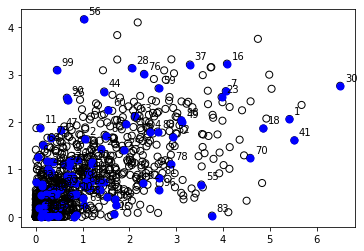

In [ ]:
from submodlib.helper import create_kernel
from submodlib import LogDeterminantFunction
model = 'resnet-18'
#for model in ["alexnet", "densenet", "resnet-18", "resnet50", "vgg"]:
features_file = "features_"+model+".hdf5"
hf = h5py.File(os.path.join(path, features_file), 'r')
groundData = hf["features"][:]
groundImages = hf["images"][:]
groundxs = [x[0] for x in groundData]
groundys = [x[1] for x in groundData]
objFL = LogDeterminantFunction(n=1000, data=groundData,mode="dense", metric="euclidean", lambdaVal=0.1)
greedyList = objFL.maximize(budget=100,optimizer='LazyGreedy', stopIfZeroGain=False, stopIfNegativeGain=False, verbose=False)
print(greedyList)
greedyXs = [groundxs[x[0]] for x in greedyList]
greedyYs = [groundys[x[0]] for x in greedyList]
plt.scatter(groundxs, groundys, s=50, facecolors='none', edgecolors='black', label="Images")
plt.scatter(greedyXs, greedyYs, s=50, color='blue', label="Greedy Set")
for label, element in enumerate(greedyList):
    plt.annotate(label, (groundxs[element[0]], groundys[element[0]]), (groundxs[element[0]]+0.1, groundys[element[0]]+0.1))

In [ ]:
l = []
for ele in greedyList:
  print(groundImages[ele[0]].decode())
  l.append(groundImages[ele[0]].decode())

TY_IR_3850.bmp
TV_IR_0591.bmp
TV_IR_1870.bmp
TY_IR_3727.bmp
TV_IR_1947.bmp
TV_IR_1488.bmp
TY_IR_2147.bmp
TV_IR_1932.bmp
TV_IR_0025.bmp
TV_IR_0374.bmp
TV_IR_1295.bmp
TV_IR_1914.bmp
TY_IR_2020.bmp
TV_IR_1369.bmp
TV_IR_1202.bmp
TV_IR_1309.bmp
TV_IR_1533.bmp
TY_IR_3947.bmp
TV_IR_0531.bmp
TY_IR_2738.bmp
TY_IR_2545.bmp
TY_IR_2087.bmp
TV_IR_1281.bmp
TV_IR_1906.bmp
TV_IR_0589.bmp
TV_IR_0387.bmp
TV_IR_0056.bmp
TY_IR_3647.bmp
TV_IR_1368.bmp
TY_IR_2921.bmp
TV_IR_1407.bmp
TV_IR_0686.bmp
TY_IR_2976.bmp
TV_IR_0766.bmp
TV_IR_1928.bmp
TV_IR_0314.bmp
TV_IR_1597.bmp
TV_IR_1773.bmp
TY_IR_2624.bmp
TV_IR_0756.bmp
TV_IR_0397.bmp
TV_IR_0595.bmp
TV_IR_1752.bmp
TY_IR_2170.bmp
TV_IR_1209.bmp
TY_IR_3960.bmp
TV_IR_1283.bmp
TV_IR_1803.bmp
TY_IR_3824.bmp
TV_IR_1074.bmp
TV_IR_1390.bmp
TV_IR_1129.bmp
TV_IR_1948.bmp
TV_IR_0295.bmp
TY_IR_3369.bmp
TV_IR_1845.bmp
TV_IR_1754.bmp
TV_IR_1939.bmp
TY_IR_2834.bmp
TV_IR_0260.bmp
TV_IR_0781.bmp
TV_IR_1301.bmp
TY_IR_2150.bmp
TV_IR_1336.bmp
TV_IR_1017.bmp
TV_IR_1206.bmp
TV_IR_1884

[(999, 0.09531017980432493), (824, -1.2071476987179304), (902, -1.509860958849026), (174, -1.5965786639889379), (522, -1.6621172774259434), (206, -1.7091280343170303), (483, -1.7470666140966562), (186, -1.768931339109205), (299, -1.7871355398902622), (515, -1.798865797437802), (757, -1.8077214093378917), (207, -1.8261708363978382), (316, -1.8359952944699993), (930, -1.8437000066003648), (688, -1.8541602859378443), (15, -1.860157734789699), (613, -1.864256083724458), (644, -1.8709659719878906), (987, -1.8768132644767002), (343, -1.88203385372248), (355, -1.8924938006459269), (667, -1.8988425424872237), (771, -1.9003959796608154), (491, -1.9027011264033538), (741, -1.9047314614654778), (337, -1.9076906450394044), (916, -1.912533305105855), (889, -1.9210777948153812), (794, -1.9249117431261928), (160, -1.926422326457779), (685, -1.9265336453736082), (133, -1.9283168907125667), (699, -1.9333438125775189), (621, -1.9343851652497195), (692, -1.935570319857069), (98, -1.9403461640453767), (62

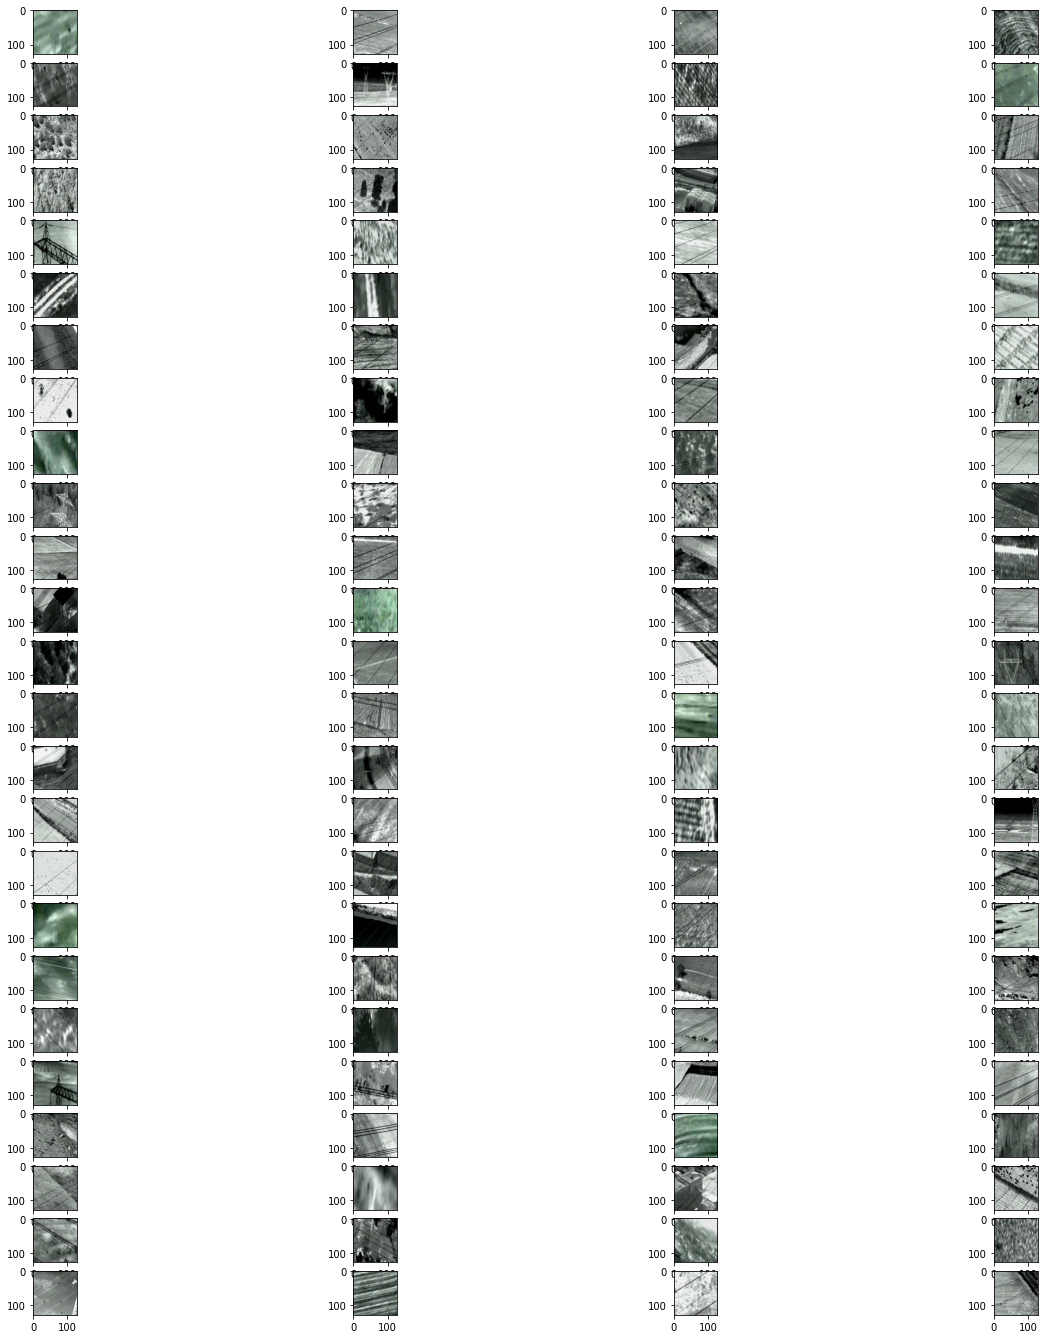

In [ ]:
print(greedyList)
row = 0
index = 1
plt.figure(figsize=(22, 24))
for elem in greedyList:
  plt.subplot(25, 4, row*5+index)
  image_path = os.path.join(path, groundImages[elem[0]].decode())
  img = cv2.imread(image_path)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 load images as BGR, convert it to RGB
  plt.imshow(img)
  index += 1
  if index == 6:
    row += 1
    index = 1

In [ ]:
import shutil
import os
os.makedirs('data')
for i in l:
  shutil.copy2('/content/final/' + i, 'data/' + i)

In [ ]:
!zip -r final_IR.zip data

  adding: data/ (stored 0%)
  adding: data/TV_IR_1939.bmp (deflated 32%)
  adding: data/TV_IR_1754.bmp (deflated 36%)
  adding: data/TV_IR_1309.bmp (deflated 35%)
  adding: data/TV_IR_1733.bmp (deflated 27%)
  adding: data/TV_IR_1336.bmp (deflated 42%)
  adding: data/TV_IR_1752.bmp (deflated 17%)
  adding: data/TV_IR_1803.bmp (deflated 27%)
  adding: data/TV_IR_1209.bmp (deflated 36%)
  adding: data/TV_IR_0756.bmp (deflated 36%)
  adding: data/TV_IR_1005.bmp (deflated 20%)
  adding: data/TV_IR_0314.bmp (deflated 38%)
  adding: data/TV_IR_1390.bmp (deflated 27%)
  adding: data/TV_IR_0686.bmp (deflated 19%)
  adding: data/TY_IR_2989.bmp (deflated 24%)
  adding: data/TY_IR_2921.bmp (deflated 45%)
  adding: data/TY_IR_3373.bmp (deflated 73%)
  adding: data/TY_IR_3727.bmp (deflated 29%)
  adding: data/TV_IR_1932.bmp (deflated 31%)
  adding: data/TY_IR_2800.bmp (deflated 42%)
  adding: data/TV_IR_0053.bmp (deflated 14%)
  adding: data/TV_IR_1488.bmp (deflated 44%)
  adding: data/TV_IR_1914.b

In [ ]:
filename